In [1]:
from datetime import datetime
print datetime.now()

2019-01-23 18:24:18.297024


# Make prediction spaces

This script uses the classifiers with the highest accuracy to get the LIs and predictions for all cases

### import modules

In [2]:
%matplotlib inline

In [3]:
import os

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

In [4]:
sns.set_style('white')
sns.set_context('poster')

### load labeler

In [5]:
myLabeler = pickle.load(open('../models/myLabeler.p', 'rb'))

In [6]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### load classifier and accuracy df

In [7]:
def makePercentileDf(accDf):

    # put the dataframe in to a 1d array
    a = np.array(accDf.stack())
    # get the percentile scores for all accuracy values
    percentileList = [(i, stats.percentileofscore(a, i)) for i in np.unique(a)]
    percentileDf = pd.DataFrame(percentileList)
    # clean up index
    percentileDf.index = percentileDf[0]
    percentileDf.drop(0, inplace=True, axis=1)
    # put back into dict, with accuracies as keys and percentiles as values
    percentileDict = percentileDf.to_dict()[1]

    # make a 2x2 table in the same format as the accDf, but with
    # percentile scores in the respective cells
    pcDf = accDf.copy()
    for i in accDf.index:
        for c in accDf.columns:
            thisCell = accDf.loc[i][round(c, 1)]
            pcDf.set_value(i, round(c, 1), percentileDict[thisCell])

    return pcDf

In [8]:
clfDict = pickle.load(open('../models/clf_1d_drop.p', 'rb'))
accDict = pickle.load(open('../models/acc_1d_drop.p', 'rb'))

accDf = pd.DataFrame(accDict).T
pcDf = makePercentileDf(accDf)

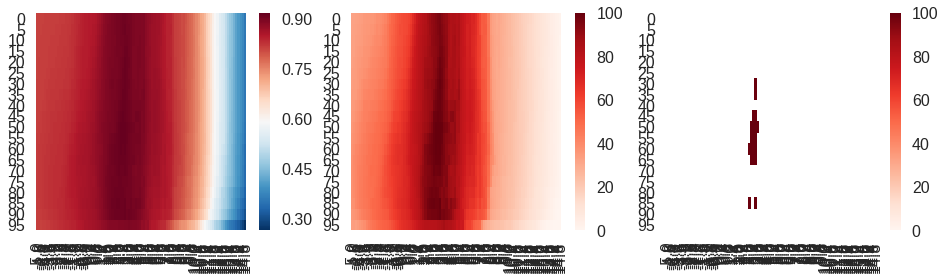

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1 = sns.heatmap(accDf, cmap='RdBu_r', ax=ax1)
ax2 = sns.heatmap(pcDf, cmap='Reds', vmin=0, vmax=100, ax=ax2)
ax3 = sns.heatmap(pcDf[pcDf > 99], cmap='Reds', vmin=0, vmax=100, ax=ax3)
plt.show()

### get the significant accuracy

In [10]:
def getGuessingRate(my_list, drop):
    groups = np.unique(np.array(my_list)[:, 0])
    if drop:
        groups = groups[groups != 'inconclusive']
    f = lambda x: len(np.where(np.array(my_list)[:, 0] == x)[-1])
    a = np.array(map(f, groups))
    guessingRate = float(a.max()) / a.sum()
    return guessingRate

In [11]:
my_train = pickle.load(open('../models/my_nest.p', 'rb'))

In [12]:
guessingRate = getGuessingRate(my_train, drop=True)

In [13]:
guessingRate

0.8125

In [14]:
def getSigMap(accDf, my_train=my_train, drop=True):
    # what is the chance of guessing correctly?
    guessingRate = getGuessingRate(my_train, drop=drop)
    # what is the sample size for the predictions?
    nOfNest = len(my_train)

    # function to compute a binomal test
    fBinom = lambda x:stats.binom_test(x*nOfNest,n=nOfNest,p=guessingRate,alternative='two-sided')

    # compute the probability of getting the accuracy in each cell by chance,
    # given the specified guessing rate and sample size
    sigMap = accDf.applymap(fBinom)

    return sigMap

### get the top parameters

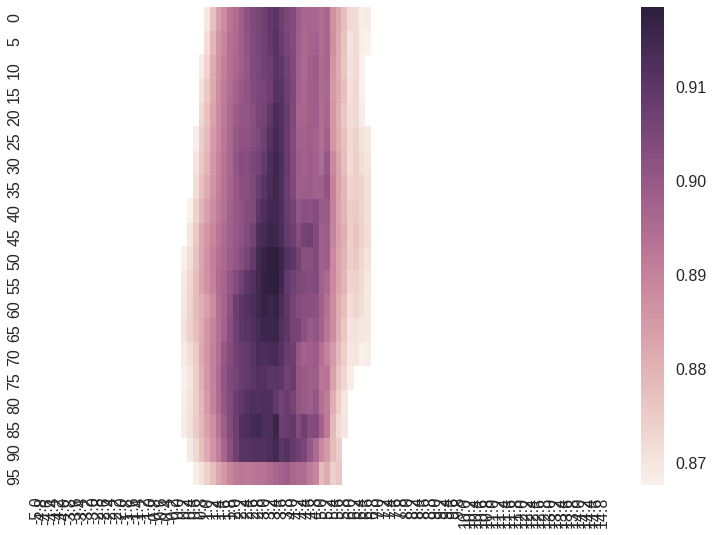

In [15]:
sigMap = getSigMap(accDf)
sns.heatmap(accDf[accDf > guessingRate][sigMap < 0.001])

collect the parameters that allow for above-chance prediction

In [16]:
aboveDf = pd.DataFrame(accDf[accDf > guessingRate][sigMap < 0.001].stack())

In [17]:
aboveDf.T

0                                                             \
        1.0       1.2       1.4      1.6       1.8       2.0      2.2   
0  0.869259  0.876991  0.883981  0.88787  0.892731  0.895093  0.89875   

                                   ...           95                      \
        2.4       2.6       2.8    ...          3.8       4.0       4.2   
0  0.901944  0.904259  0.905463    ...     0.898704  0.896296  0.895139   

                                                                         
        4.4       4.6       4.8       5.0       5.2       5.4       5.6  
0  0.895185  0.891806  0.889167  0.878102  0.881296  0.874491  0.876019  

[1 rows x 608 columns]

### predictions for one value and one parameter set

In [18]:
def makePred(x, roiPc, tThresh, clfDict, myLabeler=myLabeler):

    thisClf = clfDict[roiPc][tThresh]['clf']
    thisScaler = clfDict[roiPc][tThresh]['scaler']

    xArr = np.array(x)
    #print xArr
    #print xArr.shape
    xScaled = thisScaler.transform(xArr.reshape(1, -1 * xArr.shape[-1]))

    y_pred = thisClf.predict_proba(xScaled)

    df = pd.DataFrame(y_pred).T
    idx = [myLabeler.inverse_transform([x])[-1] for x in thisClf.classes_]
    df.index = idx

    return df

Example:

In [19]:
thesePreds = makePred([0], 0, 3, clfDict)

/data/martin/frontSub/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [20]:
thesePreds

,0
bilateral,0.678082
left,0.173603
right,0.148315


### make 1d prediction space

In [21]:
def doFixedPred(x, clfDict, aboveDf):
    dd = pd.DataFrame()
    for pc in aboveDf.index.levels[0]:
        for t in aboveDf.loc[pc].index:
            thisPred = makePred(x, pc, t, clfDict)
            thisPred = thisPred.T
            thisPred.index = [str(pc) + '_' + str(t)]
            dd = pd.concat([dd, thisPred])
    df = pd.DataFrame(dd.mean(axis=0)).T
    df.index = [str(x)]
    return df.T

In [22]:
doFixedPred([0],clfDict,aboveDf)

,[0]
bilateral,0.637615
left,0.204495
right,0.157890


In [23]:
def makeProbPreds(clfDict, aboveDf):
    df = pd.DataFrame()
    for i in np.linspace(-1, 1, 1001):
        thesePreds = doFixedPred([i], clfDict, aboveDf)
        thesePreds = thesePreds.T
        thesePreds.index = [i]
        df = pd.concat([df, thesePreds])
    return df

In [24]:
from datetime import datetime

In [25]:
alpha = 0.001

for myDrop in [True, False]:

    dropStr = ['full', 'drop'][myDrop]
    print myDrop, datetime.now()

    clfDict = pickle.load(
        open('../models/clf_%s_%s.p' % ('1d', dropStr), 'rb'))
    accDict = pickle.load(
        open('../models/acc_%s_%s.p' % ('1d', dropStr), 'rb'))
    accDf = pd.DataFrame(accDict).T
    sigMap = getSigMap(accDf, drop=myDrop)

    # get the cutoff
    sigMap = getSigMap(accDf, drop=myDrop)
    guessingRate = getGuessingRate(my_train, drop=myDrop)
    aboveDf = pd.DataFrame(accDf[accDf > guessingRate][sigMap < alpha].stack())

    aboveDf.to_csv('../models/aboveDf_clf_%s_%s.csv' % ('1d', dropStr))

    predSpaceDf = makeProbPreds(clfDict, aboveDf)

    predSpaceDf.to_csv('../models/probPreds_clf_%s_%s.csv' % ('1d', dropStr))

True 2019-01-23 18:24:28.719174
False 2019-01-23 18:35:01.285113


### plot the predictions

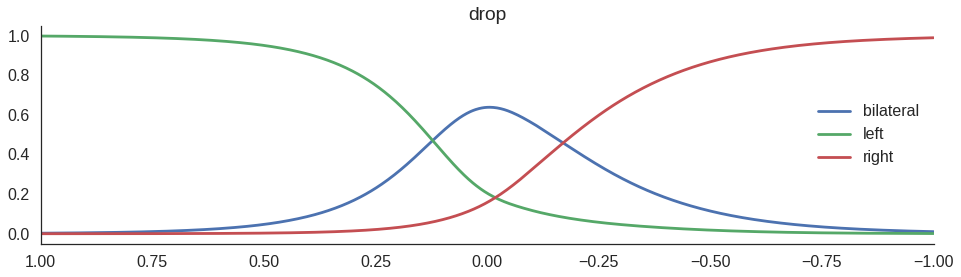

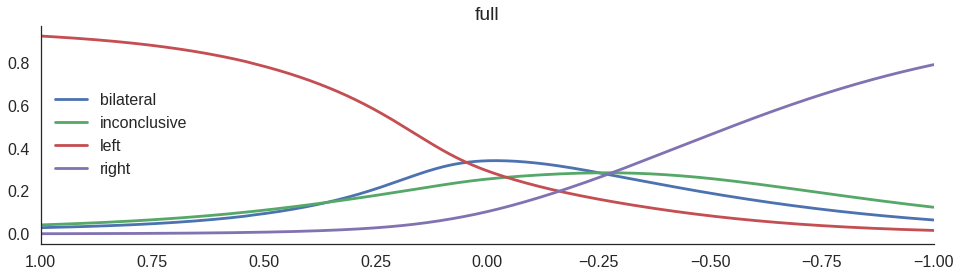

In [26]:
for myDrop in [True, False]:

    dropStr = ['full', 'drop'][myDrop]
    predSpaceDf = pd.read_csv(
        '../models/probPreds_clf_1d_%s.csv' % (dropStr), index_col=[0])
    predSpaceDf.plot(figsize=(16, 4), title=dropStr)
    sns.despine()
    plt.xlim(1, -1, -0.1)
    plt.show()

### make 2d prediction space

For the 2d case, we must run a different script to get the 2d prediction space

In [27]:
def makePredSpace(clfDict,
                  aboveDf,
                  x_min=-1,
                  x_max=1,
                  y_min=-0.1,
                  y_max=1.7,
                  myLabeler=myLabeler):

    predDf = pd.DataFrame()
    for x in np.arange(x_min, x_max, .01):
        for y in np.arange(y_min, y_max, .01):
            thesePreds = doFixedPred([x, y], clfDict, aboveDf)
            thesePreds.columns = pd.MultiIndex.from_arrays([[y], [x]])
            thesePreds = thesePreds.T
            predDf = pd.concat([predDf, thesePreds])

    return predDf

In [28]:
alpha = 0.001

for myDrop in [True, False]:

    dropStr = ['full', 'drop'][myDrop]
    print myDrop, datetime.now()

    clfDict = pickle.load(
        open('../models/clf_%s_%s.p' % ('2d', dropStr), 'rb'))
    accDict = pickle.load(
        open('../models/acc_%s_%s.p' % ('2d', dropStr), 'rb'))
    accDf = pd.DataFrame(accDict).T
    sigMap = getSigMap(accDf, drop=myDrop)

    # get the cutoff
    sigMap = getSigMap(accDf, drop=myDrop)
    guessingRate = getGuessingRate(my_train, drop=myDrop)
    aboveDf = pd.DataFrame(accDf[accDf > guessingRate][sigMap < alpha].stack())

    aboveDf.to_csv('../models/aboveDf_clf_%s_%s.csv' % ('2d', dropStr))

    predSpaceDf = makePredSpace(clfDict, aboveDf)

    predSpaceDf.to_csv('../models/probPreds_clf_%s_%s.csv' % ('2d', dropStr))

True 2019-01-23 18:50:19.462437
False 2019-01-24 01:18:29.272019


In [36]:
predSpaceDf.tail()

bilateral  inconclusive      left         right
     Unnamed: 1                                                 
1.69 0.95         0.000669  2.025082e-06  0.999329  6.339021e-08
     0.96         0.000559  1.659456e-06  0.999440  5.261249e-08
     0.97         0.000468  1.399451e-06  0.999531  4.512670e-08
     0.98         0.000387  1.156389e-06  0.999611  4.173809e-08
     0.99         0.000320  9.430314e-07  0.999679  3.983934e-08

### plot

In [30]:
def cmyk2rgb(l, bi, r, inc):

    c = float(l)
    m = float(bi)
    y = float(r)
    k = float(inc)

    r = round(255.0 - ((min(1.0, c * (1.0 - k) + k)) * 255.0))
    g = round(255.0 - ((min(1.0, m * (1.0 - k) + k)) * 255.0))
    b = round(255.0 - ((min(1.0, y * (1.0 - k) + k)) * 255.0))

    # mute the colors so they don't look as loud
    r = round(r * 0.6 + 10 * 0.4)
    g = round(g * 0.6 + 10 * 0.4)
    b = round(b * 0.6 + 10 * 0.4)

    return [r, g, b]

True 2019-01-24 06:43:23.645575


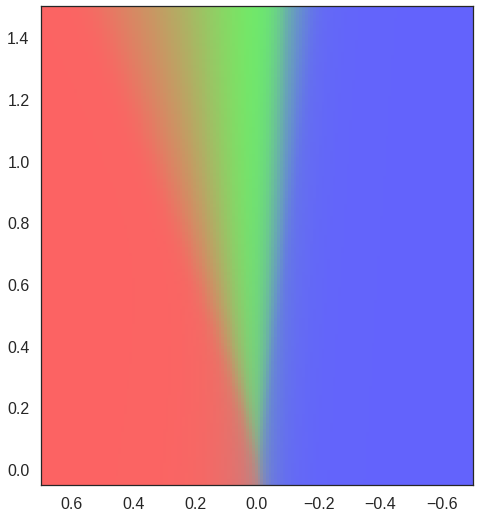

False 2019-01-24 06:49:41.349084


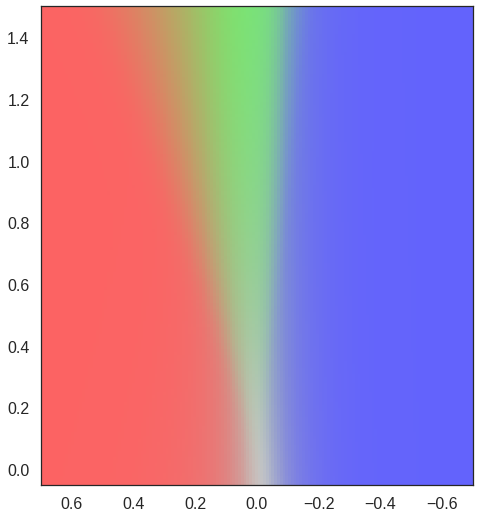

2019-01-24 06:55:58.191627


In [31]:
for myDrop in [True, False]:

    dropStr = ['full', 'drop'][myDrop]
    print myDrop, datetime.now()

    predSpaceDf = pd.read_csv(
        '../models/probPreds_clf_2d_%s.csv' % dropStr, index_col=[0, 1])
    predSpaceDf.sort_index(inplace=True)

    bigDf = pd.DataFrame()
    for i in predSpaceDf.index:

        if 'inconclusive' not in predSpaceDf.columns:
            predSpaceDf.loc[:, 'inconclusive'] = 0

        theseVals = predSpaceDf.loc[
            i, ['left', 'bilateral', 'right', 'inconclusive']]
        theseColors = cmyk2rgb(*theseVals.values)

        thisDf = pd.DataFrame(
            theseColors,
            index=['r', 'g', 'b'],
            columns=pd.MultiIndex.from_tuples([i])).T

        bigDf = pd.concat([bigDf, thisDf])

    colorDf = pd.DataFrame(index=bigDf.index)
    for i in bigDf.index:
        colorDf.loc[i, 'rgb'] = 'dummy'
        colorDf.loc[i, 'rgb'] = bigDf.loc[i, :].values
    colorDf = colorDf.unstack()['rgb']
    # transform df to 3d array
    a = np.array([list(i) for i in np.array(colorDf)])

    plt.imshow(a, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7))
    plt.xlim(0.7, -0.7, -0.1)
    plt.ylim(-0.05, 1.5, 0.1)

    plt.show()

print datetime.now()

### add contour to delineate area of "inconclusiveness"

In [32]:
bestPred = pd.DataFrame( predSpaceDf.idxmax(axis=1) ).unstack()
b = np.array(bestPred.applymap(lambda x:x=='inconclusive'))

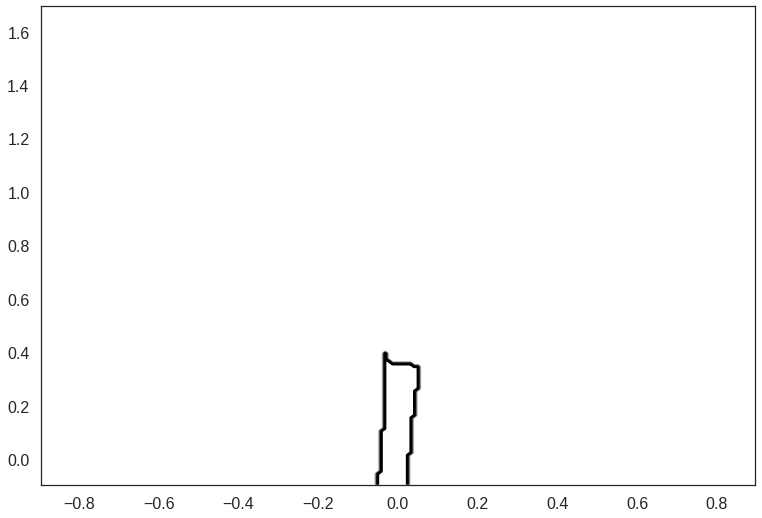

In [33]:
plt.contour(b, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7));

### store as pickels, so re-loading is faster

In [34]:
pickle.dump(a, open('../models/colors_2d_full.p','wb'))
pickle.dump(b, open('../models/contours_2d_full.p','wb'))

### check if re-loading and re-using works:

2019-01-24 06:55:59.073422


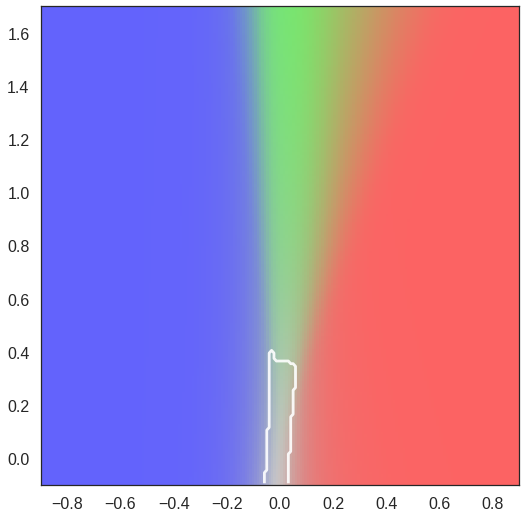

2019-01-24 06:55:59.373532


In [35]:
print datetime.now()

a = pickle.load(open('../models/colors_2d_full.p', 'rb'))
b = pickle.load(open('../models/contours_2d_full.p', 'rb'))

plt.imshow(a, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7))
plt.contour( b,colors=('white'),levels=[0],alpha=0.9,origin='lower',extent=(-0.9,0.9,-0.1,1.7),antialiased=True,zorder=99 )
plt.show()

print datetime.now()